In [1]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))
else:
    print("No GPU found.")


Torch version: 2.5.1+cu121
CUDA available: True
Device: NVIDIA GeForce MX330


In [2]:
#Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import shap
import joblib


d:\Datascience\Project\Cybersecurity_classifier\Microsoft_cybersecurity_classifier\cybersecurity\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Step 2: Load Processed Data
path = "traindata_processed.csv"
df=pd.read_csv(path,nrows=4500000)
df.head()


,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,ApplicationName,OAuthApplicationId,FileName,ResourceIdName,OSVersion,City,Day,Year,Hour,Time
0,180388628218,0,612,123247,7,6,10,2,15,1,...,3421,881,289573,3586,66,3,4,2024,6,21915
1,455266534868,88,326,210035,58,43,7,1,32,0,...,3421,881,289573,3586,66,10630,14,2024,3,10885
2,1056561957389,809,58352,712507,423,298,10,1,31,1,...,3421,881,289573,3586,66,10630,13,2024,4,17575
3,1279900258736,92,32992,774301,2,2,1,0,31,1,...,3421,881,289573,3586,66,10630,10,2024,16,59976
4,214748368522,148,4359,188041,9,74,6,2,32,0,...,3421,881,289573,3586,66,10630,15,2024,1,4087


In [4]:
df.shape

(4500000, 27)

In [5]:
# Step 3: Split Features and Target
X = df.drop("IncidentGrade", axis=1)
y = df["IncidentGrade"]

# Step 4: Train-Validation Split with Stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


Training set class distribution:
 IncidentGrade
0    0.431238
2    0.351527
1    0.217235
Name: proportion, dtype: float64
Validation set class distribution:
 IncidentGrade
0    0.431239
2    0.351527
1    0.217235
Name: proportion, dtype: float64


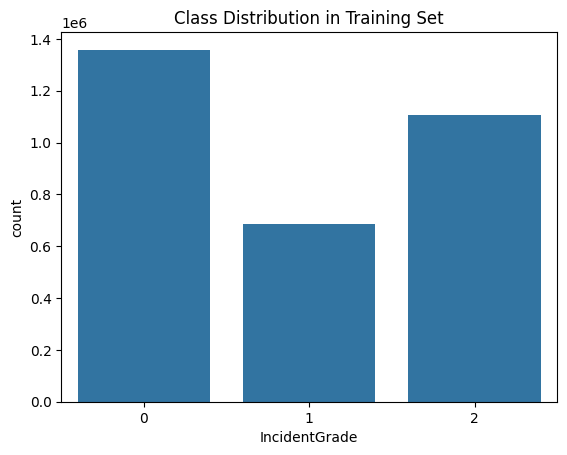

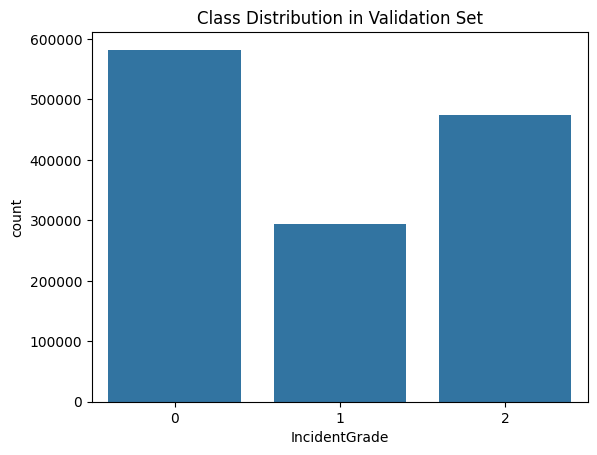

In [6]:
# Cheking class distribution  in training and validations
print("Training set class distribution:\n",y_train.value_counts(normalize=True))
print("Validation set class distribution:\n",y_val.value_counts(normalize=True))

# visualization
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set")
plt.show()

sns.countplot(x=y_val)
plt.title("Class Distribution in Validation Set")
plt.show()


In [7]:
# baseline model
baseline_model={
    'LogisticRegression':LogisticRegression(class_weight='balanced',random_state=42),
    'DecisionTreeClassifier':DecisionTreeClassifier(class_weight='balanced',random_state=42)
}


# training and evaluvation on validation set

for name,model in baseline_model.items():
    print(f"\nTraining {name}...")
    model.fit(X_train,y_train)
    y_pred=model.predict(X_val)
    print(f"{name}Classification Report:\n",classification_report(y_val,y_pred,target_names=['Class 0','Class 1','Class 2']))
    macro_f1=f1_score(y_val,y_pred,average='macro')
    print(f"{name} Macro F1 Score={macro_f1:.4f}")


Training LogisticRegression...
LogisticRegressionClassification Report:
               precision    recall  f1-score   support

     Class 0       0.51      0.49      0.50    582172
     Class 1       0.25      0.13      0.17    293267
     Class 2       0.45      0.59      0.51    474561

    accuracy                           0.45   1350000
   macro avg       0.40      0.41      0.39   1350000
weighted avg       0.43      0.45      0.43   1350000

LogisticRegression Macro F1 Score=0.3936

Training DecisionTreeClassifier...
DecisionTreeClassifierClassification Report:
               precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99    582172
     Class 1       0.98      0.98      0.98    293267
     Class 2       0.99      0.99      0.99    474561

    accuracy                           0.99   1350000
   macro avg       0.99      0.99      0.99   1350000
weighted avg       0.99      0.99      0.99   1350000

DecisionTreeClassifier Macro F1 Score=0.9

In [9]:
# Define advanced models
advanced_model = {
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=10, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, max_depth=5, random_state=42)
}

# XGBoost with GPU
try:
    advanced_model['XGBoost'] = XGBClassifier(
        n_estimators=50,
        max_depth=5,
        scale_pos_weight=1,
        random_state=42,
        tree_method='hist',
        device='cuda'
    )
except Exception as e:
    print("XGBoost failed:", e)

# LightGBM with GPU
try:
    advanced_model['LightGBM'] = LGBMClassifier(
        n_estimators=100,
        max_depth=10,
        is_unbalance=True,
        random_state=42,
        device='gpu'
    )
except Exception as e:
    print("LightGBM failed:", e)


In [10]:
import time
for name, model in advanced_model.items():
    print(f"\n Training {name}...")
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    print(f" {name} training complete in {(end - start)/60:.2f} minutes.")

    y_pred = model.predict(X_val)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

    macro_f1 = f1_score(y_val, y_pred, average='macro')
    print(f"{name} Macro F1 Score: {macro_f1:.4f}")



 Training Random Forest...
 Random Forest training complete in 9.09 minutes.

Random Forest Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      0.94      0.83    582172
     Class 1       0.81      0.72      0.76    293267
     Class 2       0.97      0.73      0.83    474561

    accuracy                           0.82   1350000
   macro avg       0.84      0.80      0.81   1350000
weighted avg       0.84      0.82      0.82   1350000

Random Forest Macro F1 Score: 0.8089

 Training Gradient Boosting...
 Gradient Boosting training complete in 103.74 minutes.

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

     Class 0       0.76      0.96      0.85    582172
     Class 1       0.91      0.65      0.76    293267
     Class 2       0.94      0.80      0.86    474561

    accuracy                           0.84   1350000
   macro avg       0.87      0.80      0.82   1350000
weighted a

d:\Datascience\Project\Cybersecurity_classifier\Microsoft_cybersecurity_classifier\cybersecurity\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:05:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost training complete in 0.44 minutes.


d:\Datascience\Project\Cybersecurity_classifier\Microsoft_cybersecurity_classifier\cybersecurity\Lib\site-packages\xgboost\core.py:729: UserWarning: [12:06:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



XGBoost Classification Report:
              precision    recall  f1-score   support

     Class 0       0.81      0.95      0.88    582172
     Class 1       0.91      0.73      0.81    293267
     Class 2       0.94      0.85      0.89    474561

    accuracy                           0.87   1350000
   macro avg       0.89      0.84      0.86   1350000
weighted avg       0.88      0.87      0.87   1350000

XGBoost Macro F1 Score: 0.8591

 Training LightGBM...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3886
[LightGBM] [Info] Number of data points in the train set: 3150000, number of used features: 26
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce MX330, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (36.05 MB) transferred to GPU in 0.106890 secs. 1 sparse feature groups
[Light

In [11]:
from sklearn.metrics import precision_score, recall_score

model_scores = {}

for name, model in advanced_model.items():
    y_pred = model.predict(X_val)
    model_scores[name] = {
        'macro_f1': f1_score(y_val, y_pred, average='macro'),
        'precision': precision_score(y_val, y_pred, average='macro'),
        'recall': recall_score(y_val, y_pred, average='macro')
    }

print(pd.DataFrame(model_scores).T.sort_values(by='macro_f1', ascending=False))


                   macro_f1  precision    recall
LightGBM           0.892002   0.910401  0.880130
XGBoost            0.859092   0.886084  0.844129
Gradient Boosting  0.823726   0.868581  0.804062
Random Forest      0.808903   0.841410  0.796492


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'learning_rate': [0.1, 0.05],
    'num_leaves': [31, 64]
}

lgbm = LGBMClassifier(device='gpu', random_state=42, is_unbalance=True)

grid = GridSearchCV(lgbm, param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Macro F1 Score:", grid.best_score_)
best_model = grid.best_estimator_


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3886
[LightGBM] [Info] Number of data points in the train set: 3150000, number of used features: 26
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce MX330, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (36.05 MB) transferred to GPU in 0.090935 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.841095
[LightGBM] [Info] Start training from score -1.526776
[LightGBM] [Info] Start training from score -1.045469
Best Parameters: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200, 'num_leaves': 64}
Best Macro F1 Score: 0.9417819123018621


In [14]:
{
    'learning_rate': 0.1,
    'max_depth': 20,
    'n_estimators': 200,
    'num_leaves': 64,
    'Best Macro F1 Score': 0.94
}


{'learning_rate': 0.1,
 'max_depth': 20,
 'n_estimators': 200,
 'num_leaves': 64,
 'Best Macro F1 Score': 0.94}

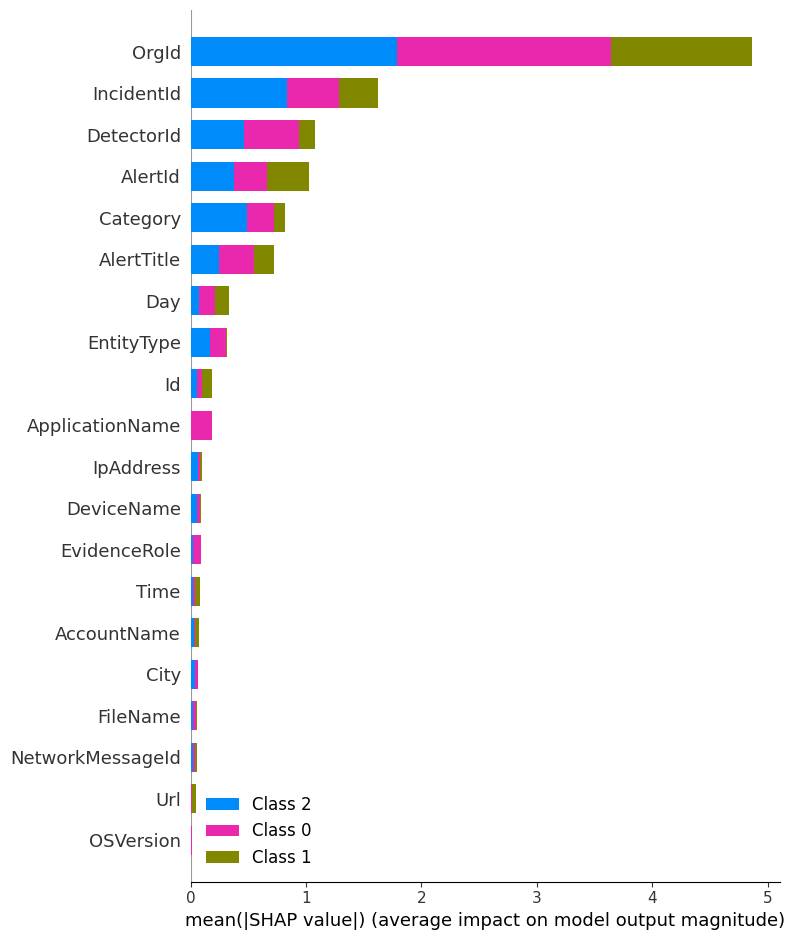

In [ ]:
# feature important using shap 
import shap

# Use a smaller sample for SHAP due to memory
X_val_sample = X_val.sample(1000, random_state=42)

# Fit SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val_sample)

# Summary bar plot
shap.summary_plot(shap_values, X_val_sample, plot_type="bar")


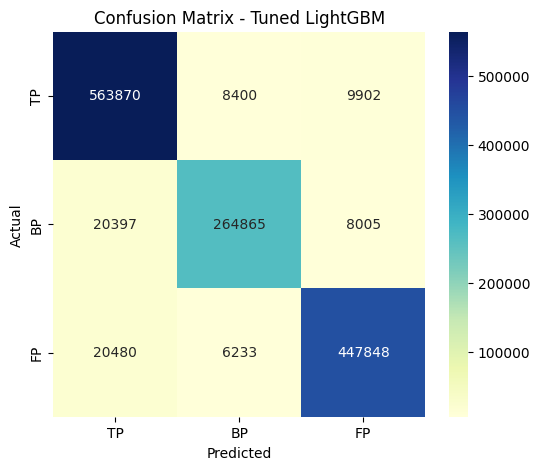

In [ ]:
# error analysis 
from sklearn.metrics import confusion_matrix


y_val_pred = best_model.predict(X_val)
conf_mat = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['TP', 'BP', 'FP'], yticklabels=['TP', 'BP', 'FP'])
plt.title("Confusion Matrix - Tuned LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [18]:
# Load processed test set
test_df = pd.read_csv("testdata_processed.csv")
X_test = test_df.drop("IncidentGrade", axis=1)
y_test = test_df["IncidentGrade"]

# Predict and evaluate
y_test_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report, f1_score

print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))

print("Test Set Macro F1 Score:", f1_score(y_test, y_test_pred, average='macro'))


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92   1752940
           1       0.89      0.84      0.86    902698
           2       0.92      0.93      0.93   1492354

    accuracy                           0.91   4147992
   macro avg       0.91      0.90      0.90   4147992
weighted avg       0.91      0.91      0.91   4147992

Test Set Macro F1 Score: 0.9021489723365592


In [20]:

# Define model performance data
data = {
    'Model': [
        'Logistic Regression',
        'Decision Tree',
        'Random Forest',
        'Gradient Boosting',
        'XGBoost',
        'LightGBM',
        'LightGBM (Tuned)'
    ],
    'Macro F1 Score': [
        0.3936,
        0.9875,
        0.8089,
        0.8237,
        0.8591,
        0.8920,
        0.9418
    ],
    'Accuracy': [
        0.45,
        0.99,
        0.82,
        0.84,
        0.87,
        0.90,
        0.91  # or use your test score here
    ],
    'Comments': [
        'Very low performance, underfits',
        'Too perfect — likely overfits',
        'Good, but weaker on Class 2',
        'Better than RF, but slow',
        'Strong and balanced',
        'Fast and accurate',
        'Best overall model'
    ]
}

# Create DataFrame
model_comparison_df = pd.DataFrame(data)

# Display table
print(model_comparison_df.to_string(index=False))


              Model  Macro F1 Score  Accuracy                        Comments
Logistic Regression          0.3936      0.45 Very low performance, underfits
      Decision Tree          0.9875      0.99   Too perfect — likely overfits
      Random Forest          0.8089      0.82     Good, but weaker on Class 2
  Gradient Boosting          0.8237      0.84        Better than RF, but slow
            XGBoost          0.8591      0.87             Strong and balanced
           LightGBM          0.8920      0.90               Fast and accurate
   LightGBM (Tuned)          0.9418      0.91              Best overall model


In [19]:
import joblib
joblib.dump(best_model, "best_lightgbm_model.pkl")


['best_lightgbm_model.pkl']